In [5]:
import pandas as pd
# https://github.com/SohierDane/BigQuery_Helper
from bq_helper import BigQueryHelper
from google.cloud import bigquery
from google.oauth2 import service_account
import google.auth
from google.cloud import bigquery
from google.cloud import bigquery_storage

In [9]:
import google.cloud.bigquery_storage_v1.client
from functools import partialmethod

# Set a two hours timeout
google.cloud.bigquery_storage_v1.client.BigQueryReadClient.read_rows = partialmethod(google.cloud.bigquery_storage_v1.client.BigQueryReadClient.read_rows, timeout=3600*2) 

In [46]:
credentials = service_account.Credentials.from_service_account_file('My First Project-ff75947ad69d.json')
your_project_id = 'crypto-parser-298009'
bqclient = bigquery.Client(credentials=credentials, project=your_project_id)
query_string = """SELECT author, created_utc, id FROM `fh-bigquery.reddit_comments.2005`"""
df = bqclient.query(query_string).to_dataframe()
for i in range(2006,2009):
    query_string = """SELECT author, created_utc, id FROM `fh-bigquery.reddit_comments."""+str(i)+'`'
    df2 = bqclient.query(query_string).to_dataframe()   
    df=df.append(df2, ignore_index=True)    
print(df.head())
print(len(df))

       author  created_utc     id
0   [deleted]   1135524272  c1996
1   [deleted]   1135528315  c1999
2  paulgraham   1135522009  c1992
3        cg84   1135525426  c1997
4  paulgraham   1135521881  c1991
9388316


In [47]:
len(df.author.unique())

153062

In [48]:
len(df.id.unique())

9388316

In [57]:
#remove comments from deleted users
data = df[df.author != '[deleted]']

In [58]:

data=data[['author', 'created_utc', 'id']].copy()
data=data.rename(columns={'author': 'id','id': 'tweetid'})
data['local_datetime'] = pd.to_datetime(data['created_utc'] , unit='s')
data['weekday'] = pd.DatetimeIndex(data['local_datetime']).strftime("%A")
data['time_hour'] = pd.DatetimeIndex(data['local_datetime']).hour

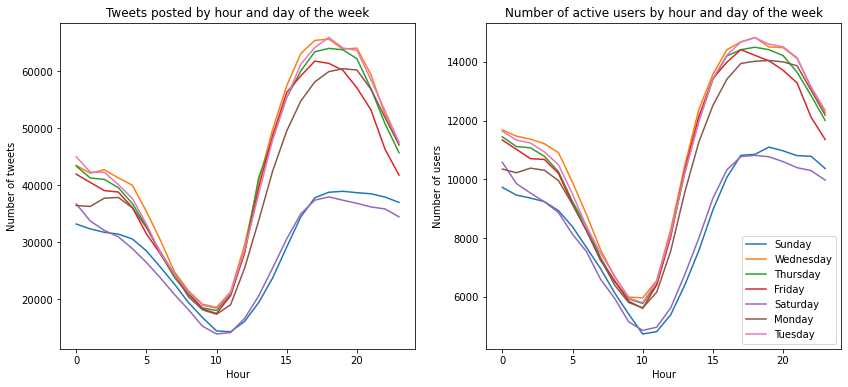

In [59]:
import numpy as np
import matplotlib.pyplot as plt

daily_activity = data.groupby(['weekday','time_hour'],as_index=False)
tweets_stats=daily_activity.size()
days=data.weekday.unique()
users_stats=daily_activity.nunique()

fig, axs = plt.subplots(1, 2, figsize=(14,6), sharex = True)
for day in days:
    daily_tweets=users_stats[users_stats.weekday==str(day)]
    axs[0].plot(daily_tweets.time_hour,daily_tweets.tweetid,label=str(day))
    axs[1].plot(daily_tweets.time_hour,daily_tweets.id,label=str(day))
    
    
axs[0].set_title('Tweets posted by hour and day of the week')
axs[0].set_xlabel('Hour')
axs[0].set_ylabel('Number of tweets')
axs[1].set_title('Number of active users by hour and day of the week')
axs[1].set_xlabel('Hour')
axs[1].set_ylabel('Number of users')
axs[1].legend()

In [60]:
grouped_by_users=data.groupby(['id'],as_index=False)
users=pd.DataFrame(data=grouped_by_users.size())
users=users.rename(columns={'size': 'statuses_count'})

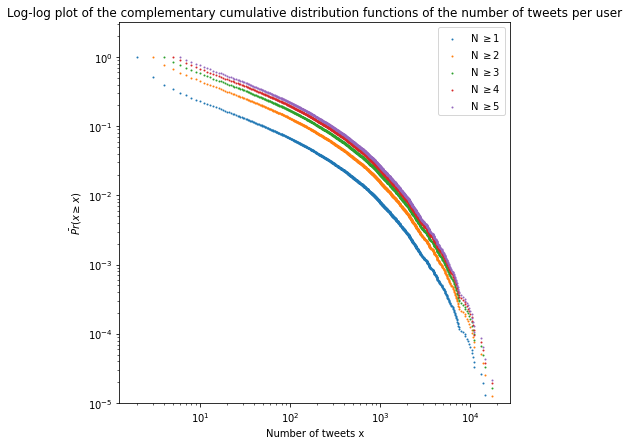

In [61]:
plt.figure(figsize=(7,7))

#We compute the ordonned list of occurences of each number of tweets: 
#tweet_bincount = [nbr of egos with 0 tweet, nbr of egos with 1 tweet, ... , nbr of egos with max_number tweets]
tweet_bincount = np.bincount(users.statuses_count)

#Using tweet_bincount, we fill tweet_sum[i] with the sum of all egos having more than i tweets:
#tweet_sum = [nbr of egos with at least 0 tweet, nbr of egos with at least 1 tweet, ... , nbr egos with at least max_number tweets]
tweet_sum=np.ones(len(tweet_bincount))*tweet_bincount.sum()
tweet_sum[1:]-=np.cumsum(tweet_bincount)[:-1]
        
    
for i in range(1,6):
    #We isolate the tweet_sum values for the sample N>=i and convert to proportions to get the CCDF 
    #(by dividing by the total number of egos in the desired sample)
    ccdf=tweet_sum[i:]
    ccdf=ccdf/ccdf[0]
    
    #The x vector contains the range of tweets for our sample, 
    #we need to adjust its dimensions to avoid having a zero in it (due to the use of the logarithm for our plot) 
    x=list(range(min(users[users.statuses_count>=i].statuses_count.values.astype(int))+1, \
                 max(users[users.statuses_count>=i].statuses_count.values.astype(int))+2))
    
    #If the probability does not change between two consecutive x, it means that the element had 0 occurence in tweet_bincount
    #In order to eliminate the duplicates in the plot, we fill a dataframe with x and ccdf 
    #and use the df.drop_duplicates function.
    xy=pd.DataFrame(data=None)
    xy['x']=x
    xy['ccdf']=ccdf
    xy=xy.drop_duplicates(subset='ccdf',keep='last')
    plt.scatter(xy.x.values,xy.ccdf.values,s=1,label="N $\geq$"+str(i))
    plt.loglog()

#Plot config
plt.ylim([10**(-5),10**0.5])
plt.xlabel('Number of tweets x')
plt.ylabel(r'$\bar{Pr}(x \geq x)$')
plt.title('Log-log plot of the complementary cumulative distribution functions of the number of tweets per user')
plt.legend()
plt.show()

In [63]:
data.to_csv('reddit_comments_2005-2009.csv')